TensorFlow opublikował Speech Commands Datasets. Baza danych zawiera 65 tysięcy jednosekundowych nagrań 30 krótkich słów w języku angielskim, wypowiedzianych przez kilka ttsięcy różnych osób. W trakcie laboratorium zostaną użyte głębokie sieci neuronowe do rozpoznawania tych słów.

Baza nagrań może być pobrana stąd [tutaj](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).

**Implementacja modelu Speech-to-Text w Python'ie od podstaw**

**Import niezbędnych bibliotek**

W pierwszej kolejności importujemy biblioteki niezbędne do przetwarzania analizowanych danych. LibROSA i SciPy są bibiotekami Python'a używanymi do przetwarzania sygnałów audio.

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import random

warnings.filterwarnings("ignore")

In [2]:
labels = ['wow', 'seven', 'four', 'cat', 'yes']
train_audio_path = 'train/audio/'

all_wave = []
all_label = []

for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000): 
            all_wave.append(samples)
            all_label.append(label)

wow
seven
four
cat
yes


In [3]:
def create_word_list(word):
    return [all_wave[i] for i in range(len(all_wave)) if all_label[i] == word]

word_wave = {}
for word in labels:
    word_wave[word] = create_word_list(word)
    random.shuffle(word_wave[word])
    print(len(word_wave[word]))

1525
2170
2158
1515
2157


In [4]:
valid_wave = []
valid_label = []

test_wave = []
test_label = []
for word in labels:
    valid_wave += word_wave[word][-200:]
    valid_label += 200*[word]
    test_wave += word_wave[word][-700:-200]
    test_label += 500*[word]

In [5]:
training_waves = []
training_labels = []
count = [10, 20, 50 ,100, 200 ,500]
for el in count:
    train_wave = []
    train_label = []
    for word in labels:
        train_wave += word_wave[word][:el]
        train_label += el*[word]
    training_waves.append(train_wave)
    training_labels.append(train_label)

Konwertujemy etykiety tekstowe do kodów całkowitoliczbowych, wymaganych do treningu klasyfikatora:

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test=le.fit_transform(test_label)
y_valid=le.transform(valid_label)
y_train = []
print(y_valid.shape)
for i in range(len(training_labels)):
    y_train.append(le.transform(training_labels[i]))
classes= list(le.classes_)

(1000,)


Zaczyna się magia frameworku keras...

Konwertujemy całkowitoliczbowe etykiery do jednego wektora:

In [7]:
from keras.utils import np_utils
y_test=np_utils.to_categorical(y_test, num_classes=len(labels))
y_valid=np_utils.to_categorical(y_valid, num_classes=len(labels))
for i in range(len(y_train)):
    y_train[i]=np_utils.to_categorical(y_train[i], num_classes=len(labels))
print(y_valid.shape)
print(y_valid)

Using TensorFlow backend.


(1000, 5)
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


Przerabiamy macierze 2D na 3D ponieważ takiego wejścia spodziewa się sieć, która będzie użyta do rozpoznawania komend głosowych:

In [8]:
import sklearn
valid_wave = np.array(valid_wave).reshape(-1,8000,1)
test_wave = np.array(test_wave).reshape(-1,8000,1)
for i in range(len(training_waves)):
    training_waves[i] = np.array(training_waves[i]).reshape(-1,8000,1)
    
valid_wave, y_valid = sklearn.utils.shuffle(valid_wave, y_valid)
test_wave, y_test = sklearn.utils.shuffle(test_wave, y_test)
for i in range(len(training_waves)):
    training_waves[i], y_train[i] = sklearn.utils.shuffle(training_waves[i], y_train[i])

**Budowa modelu**

Budujemy model korzystając z API frameworku Keras.

In [9]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def build_new_model():
    K.clear_session()
    inputs = Input(shape=(8000,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    outputs = Dense(len(labels), activation='softmax')(conv)
    model = Model(inputs, outputs)
    
    return model

In [10]:
models = []
histories = []
for i in range(len(training_waves)):
    model = build_new_model()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
    history = model.fit(training_waves[i], y_train[i] ,epochs=7, callbacks=[es], batch_size=32, validation_data=(valid_wave,y_valid))
    histories.append(history)
    models.append(model)
    filename = "model_" + str(count[i])
    model.save(filename)

Train on 50 samples, validate on 1000 samples
Epoch 1/7
50/50 [==============================] - 2s 32ms/step - loss: 1.6198 - accuracy: 0.2200 - val_loss: 1.6028 - val_accuracy: 0.2330
Epoch 2/7
50/50 [==============================] - 1s 25ms/step - loss: 1.5614 - accuracy: 0.4600 - val_loss: 1.5963 - val_accuracy: 0.2380
Epoch 3/7
50/50 [==============================] - 1s 27ms/step - loss: 1.5380 - accuracy: 0.2800 - val_loss: 1.5934 - val_accuracy: 0.2330
Epoch 4/7
50/50 [==============================] - 1s 26ms/step - loss: 1.4701 - accuracy: 0.4600 - val_loss: 1.6084 - val_accuracy: 0.2200
Epoch 5/7
50/50 [==============================] - 1s 26ms/step - loss: 1.4470 - accuracy: 0.3400 - val_loss: 1.6314 - val_accuracy: 0.2450
Epoch 6/7
50/50 [==============================] - 1s 28ms/step - loss: 1.3364 - accuracy: 0.3600 - val_loss: 1.6608 - val_accuracy: 0.2420
Epoch 7/7
50/50 [==============================] - 1s 27ms/step - loss: 1.3786 - accuracy: 0.5200 - val_loss: 1.68

**Wykres diagnostyczny**

Wizualizacja pomaga nam zrozumieć, jak działa sieć na danych treningiwych, a jak na walidacyjnych:

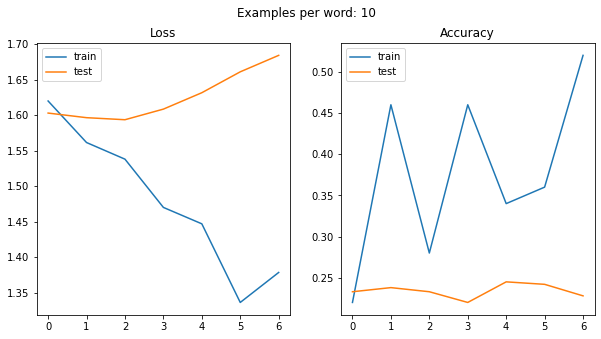

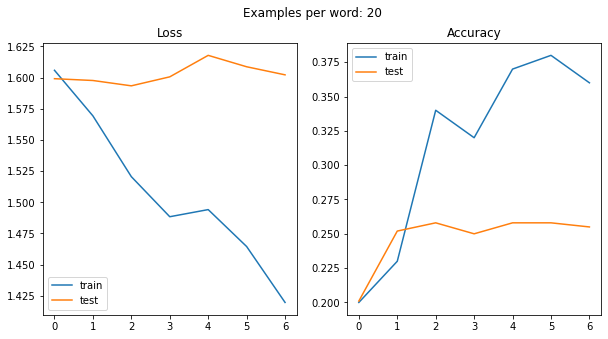

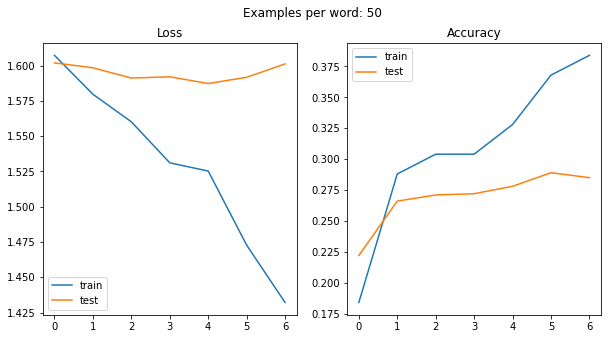

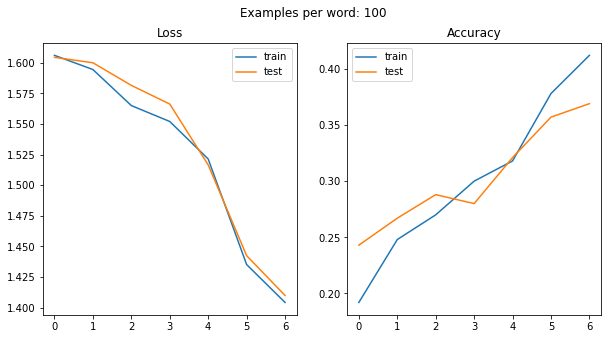

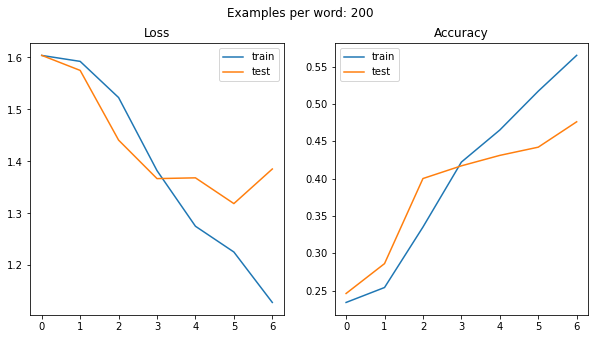

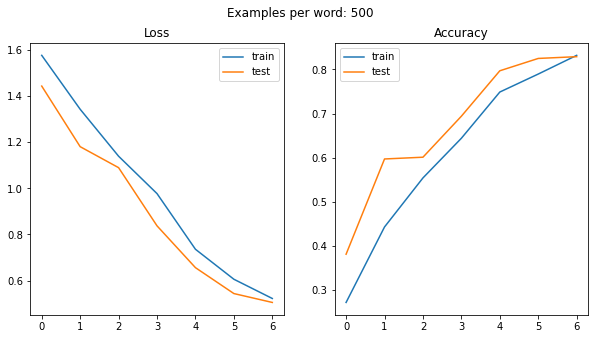

In [11]:
from matplotlib import pyplot
i=0
for history in histories:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.legend()
    ax1.set_title("Loss")
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.legend()
    ax2.set_title("Accuracy")
    fig.suptitle("Examples per word: "+ str(count[i]))
    fig.show()
    i += 1

Definiujemy funkcję, która znajduje wyraz odpowiadający sygnałowi audio::

In [12]:
def predict(audio, model_name):
    prob=model_name.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [13]:
from prettytable import PrettyTable
def show_table(content, labels, title):
    table = PrettyTable()
    table.field_names = labels
    table.title = title
    if not title == "Confusion Table in percentage":
        table.add_rows(content.astype('int'))
    else:
        table.add_rows(content)
    table._field_names.insert(0,"")
    table._align[""] = 'c' 
    table._valign[""] = 't' 
    for i, _ in enumerate(table._rows): 
        table._rows[i].insert(0, labels[i]) 
    print(table)

**Predykcja**
Sprawdzamy działanie wytrenowanej sieci na zbiorze testowym

In [14]:
from keras.models import load_model
from sklearn.metrics import classification_report
models = ["model_" + str(el) for el in count]
for model_name in models:
    model = load_model(model_name)
    real_value = []
    expected_value = []
    confusion_matrix = np.zeros((len(labels),len(labels)))
    for index in range(len(test_wave)):
        samples = test_wave[index].ravel()
        expected_value.append(classes[np.argmax(y_test[index])])
        real_value.append(predict(samples, model))
        column = classes.index(predict(samples, model))
        row = np.argmax(y_test[index])
        confusion_matrix[row][column] += 1
    print("-----------------------STATISTICS-FOR-"+model_name.upper()+"--------------------------")
    show_table(confusion_matrix, classes, "Confusion Table")
    show_table((confusion_matrix/len(test_wave)*100).round(2), classes, "Confusion Table in percentage")
    print(classification_report(expected_value, real_value, target_names=classes))
    print("\n------------------------------------------------------------------------\n\n")

-----------------------STATISTICS-FOR-MODEL_10--------------------------
+----------------------------------------+
|            Confusion Table             |
+-------+-----+------+-------+-----+-----+
|       | cat | four | seven | wow | yes |
+-------+-----+------+-------+-----+-----+
|  cat  | 146 |  42  |   75  | 162 |  75 |
|  four | 134 |  55  |   47  | 231 |  33 |
| seven | 164 |  49  |   77  | 181 |  29 |
|  wow  | 119 |  54  |   54  | 219 |  54 |
|  yes  | 194 |  50  |   96  |  84 |  76 |
+-------+-----+------+-------+-----+-----+
+-------------------------------------------+
|       Confusion Table in percentage       |
+-------+------+------+-------+------+------+
|       | cat  | four | seven | wow  | yes  |
+-------+------+------+-------+------+------+
|  cat  | 5.84 | 1.68 |  3.0  | 6.48 | 3.0  |
|  four | 5.36 | 2.2  |  1.88 | 9.24 | 1.32 |
| seven | 6.56 | 1.96 |  3.08 | 7.24 | 1.16 |
|  wow  | 4.76 | 2.16 |  2.16 | 8.76 | 2.16 |
|  yes  | 7.76 | 2.0  |  3.84 | 3.36 | 3